
## Table of Contents

1. Data Pre-processing.
2. Feature Engineering.
3. Exploratory Data Analysis.
4. Model Selection.
5. Hyperparameter tuning.
6. Feature Importance.
7. Model Interpretation.
8. Generating Submission.

In [1]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV


## 1. Data Preprocessing.

In [70]:
# reading test and train df
train_df = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')

In [3]:
#displaying the columns of train df
train_df.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')

In [4]:
# Check the data shape and sample records
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Sample records from training data:")
print(train_df.head())

Training data shape: (74051, 10)
Test data shape: (49368, 9)
Sample records from training data:
   id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0   0   I  1.5250    1.1750  0.3750  28.973189       12.728926   
1   1   I  1.1000    0.8250  0.2750  10.418441        4.521745   
2   2   M  1.3875    1.1125  0.3750  24.777463       11.339800   
3   3   F  1.7000    1.4125  0.5000  50.660556       20.354941   
4   4   I  1.2500    1.0125  0.3375  23.289114       11.977664   

   Viscera Weight  Shell Weight  Age  
0        6.647958      8.348928    9  
1        2.324659      3.401940    8  
2        5.556502      6.662133    9  
3       10.991839     14.996885   11  
4        4.507570      5.953395    8  


In [5]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

Missing values in training data:
id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64


Conclusion - No missing values encountered so we don't have to use imputation techniques or one that involves dropping rows/columns

In [6]:
train_df

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...,...
74046,74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8


## 2. Feature Engineering

In [71]:
#Creating a new feature 'Volume' by multiplying Length, Diameter, and Height
train_df['Volume'] = train_df['Length'] * train_df['Diameter'] * train_df['Height']
test_df['Volume'] = test_df['Length'] * test_df['Diameter'] * test_df['Height']

## 3. EDA

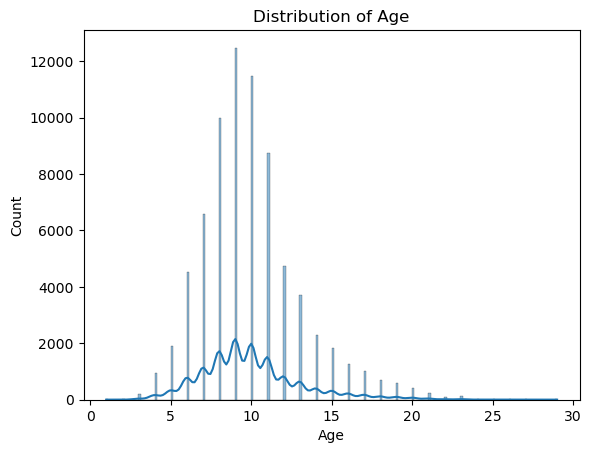

In [8]:
# Explore the target variable 'Age'
sns.histplot(train_df['Age'], kde=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show()

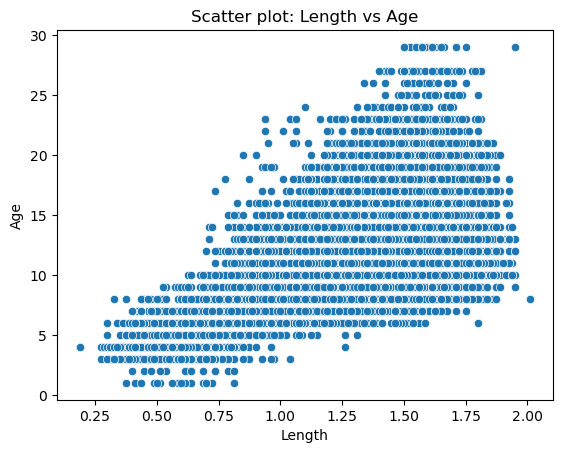

In [9]:
# Explore relationships between features and the target variable using scatter plots, box plots, etc.
sns.scatterplot(x='Length', y='Age', data=train_df)
plt.xlabel('Length')
plt.ylabel('Age')
plt.title('Scatter plot: Length vs Age')
plt.show()


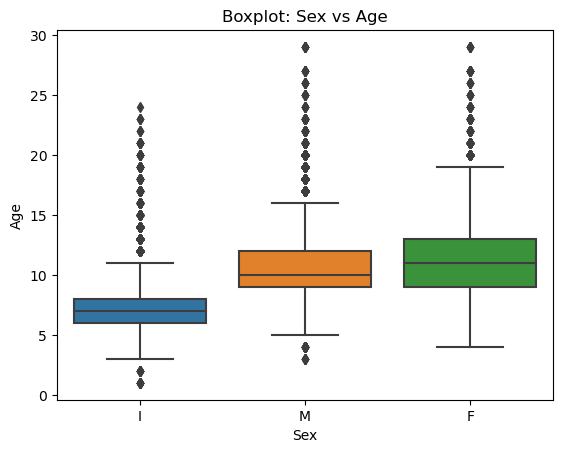

In [10]:
# Explore the relationship between 'Sex' and 'Age'
sns.boxplot(x='Sex', y='Age', data=train_df)
plt.xlabel('Sex')
plt.ylabel('Age')
plt.title('Boxplot: Sex vs Age')
plt.show()

Clearly, We have encountered outliers and this needs to be treated via statistical-methods. Let's use z-score for the same.

1. Calculate the z-scores for the 'Age' variable:


In [11]:
from scipy import stats

# Calculate z-scores for 'Age'
train_df['Age_zscore'] = stats.zscore(train_df['Age'])

2. Defining a threshold for z-score above which data points will be considered outliers. For example, let's consider a threshold of 2.

In [12]:
zscore_threshold = 2


3. Removing the outliers based on the z-score threshold:


In [13]:
# Filter out the outliers
train_df_filtered = train_df[train_df['Age_zscore'].abs() < zscore_threshold]

# Remove the 'Age_zscore' column from the filtered dataset
train_df_filtered = train_df_filtered.drop('Age_zscore', axis=1)

# Check the shape of the filtered dataset
print("Shape of filtered dataset:", train_df_filtered.shape)


Shape of filtered dataset: (70521, 11)


4. Visualizing the updated boxplot after removing outliers:


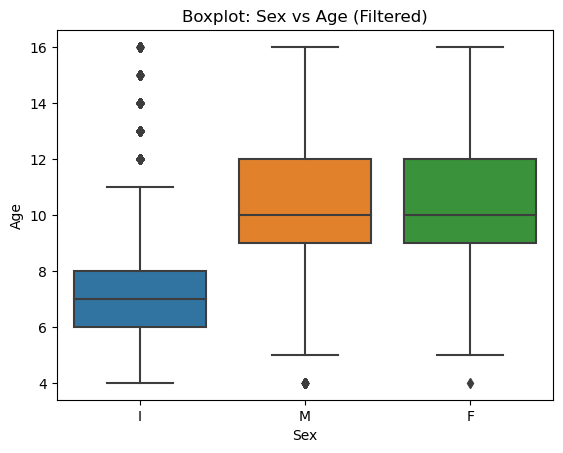

In [14]:
# Visualize the relationship between 'Sex' and 'Age' after removing outliers
sns.boxplot(x='Sex', y='Age', data=train_df_filtered)
plt.xlabel('Sex')
plt.ylabel('Age')
plt.title('Boxplot: Sex vs Age (Filtered)')
plt.show()


Outliers've been significantly reduced.

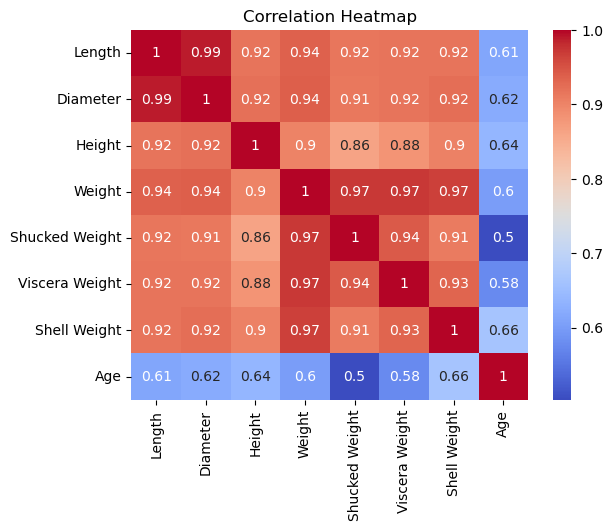

In [15]:
# Explore the correlation between numerical features
corr_matrix = train_df[['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Age']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

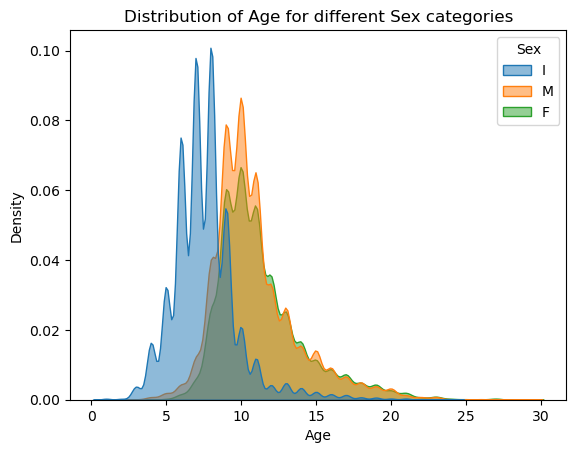

In [16]:
# Compare the distribution of 'Age' for different 'Sex' categories
sns.kdeplot(data=train_df, x='Age', hue='Sex', fill=True, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Age for different Sex categories')
plt.show()


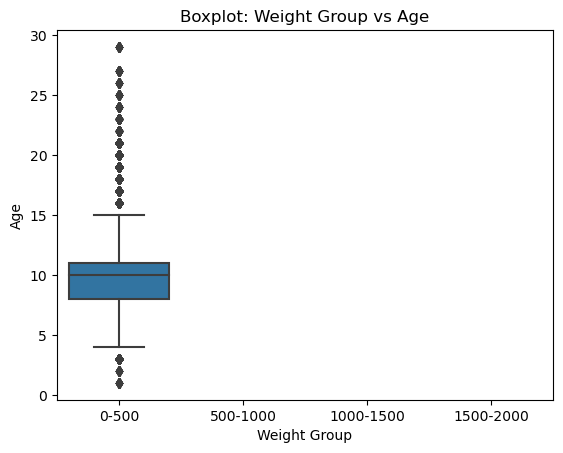

In [17]:
# Explore the distribution of 'Age' across different ranges of 'Weight'
train_df['Weight_Group'] = pd.cut(train_df['Weight'], bins=[0, 500, 1000, 1500, 2000], labels=['0-500', '500-1000', '1000-1500', '1500-2000'])
sns.boxplot(x='Weight_Group', y='Age', data=train_df)
plt.xlabel('Weight Group')
plt.ylabel('Age')
plt.title('Boxplot: Weight Group vs Age')
plt.show()

Outlier detected and it needs to be treated. Let's use z-score.

1. Calculating the z-scores for the 'Age' variable within each weight group.


In [18]:
# Group the data by 'Weight_Group' and calculate z-scores for 'Age' within each group
train_df['Age_zscore'] = train_df.groupby('Weight_Group')['Age'].transform(lambda x: stats.zscore(x))


2. Defining a threshold for z-score above which data points will be considered outliers. Let's consider a threshold of 3


In [19]:
zscore_threshold = 3


3. Removing the outliers based on the z-score threshold within each weight group:


In [20]:
# Filter out the outliers within each weight group
train_df_filtered = train_df[np.abs(train_df['Age_zscore']) < zscore_threshold]

# Remove the 'Age_zscore' column from the filtered dataset
train_df_filtered = train_df_filtered.drop('Age_zscore', axis=1)

# Check the shape of the filtered dataset
print("Shape of filtered dataset:", train_df_filtered.shape)


Shape of filtered dataset: (73057, 12)


4. Visualizing the updated boxplot after removing outliers within each weight group:


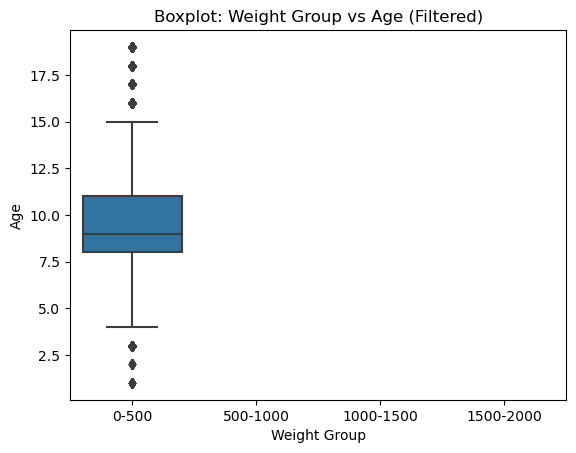

In [21]:
# Visualize the distribution of 'Age' across different weight groups after removing outliers
sns.boxplot(x='Weight_Group', y='Age', data=train_df_filtered)
plt.xlabel('Weight Group')
plt.ylabel('Age')
plt.title('Boxplot: Weight Group vs Age (Filtered)')
plt.show()


Outliers have significantly removed.

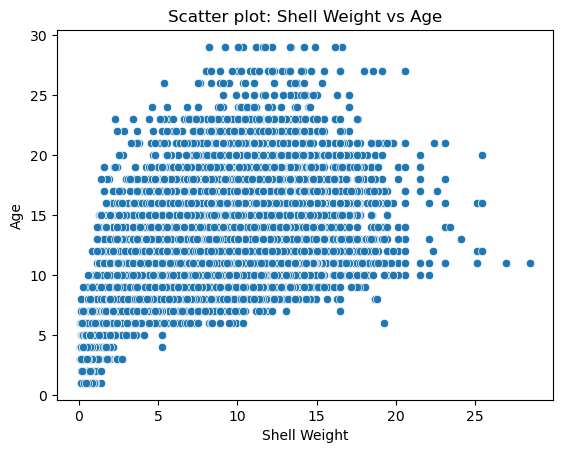

In [22]:
# Explore the relationship between 'Shell Weight' and 'Age' using a scatter plot
sns.scatterplot(x='Shell Weight', y='Age', data=train_df)
plt.xlabel('Shell Weight')
plt.ylabel('Age')
plt.title('Scatter plot: Shell Weight vs Age')
plt.show()

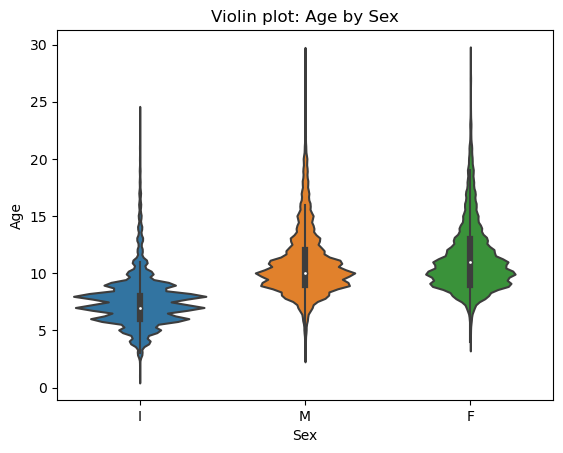

In [23]:
# Explore the distribution of 'Age' by grouping it with another categorical feature, such as 'Sex'
sns.violinplot(x='Sex', y='Age', data=train_df)
plt.xlabel('Sex')
plt.ylabel('Age')
plt.title('Violin plot: Age by Sex')
plt.show()

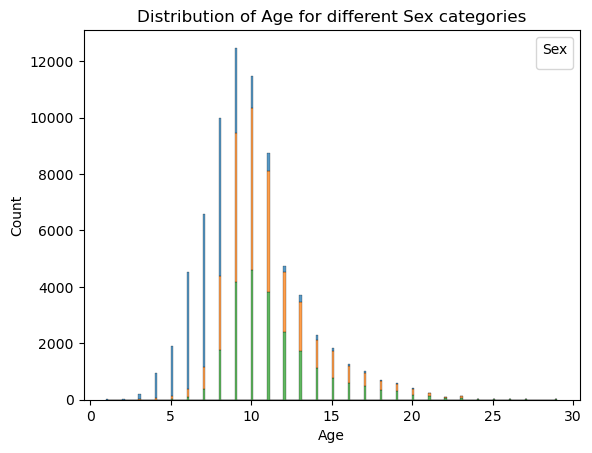

In [24]:
# Compare the distribution of 'Age' for different 'Sex' categories using a histogram
sns.histplot(data=train_df, x='Age', hue='Sex', multiple='stack')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age for different Sex categories')
plt.legend(title='Sex')
plt.show()

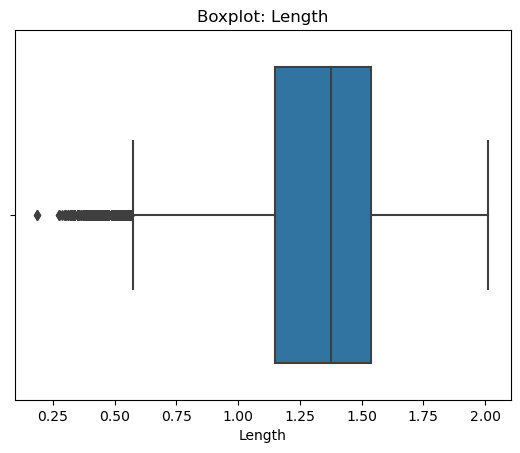

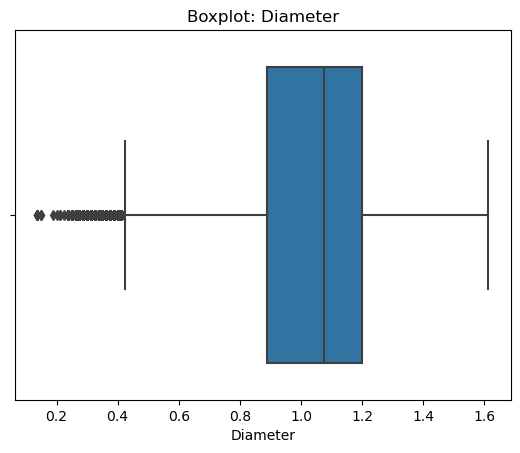

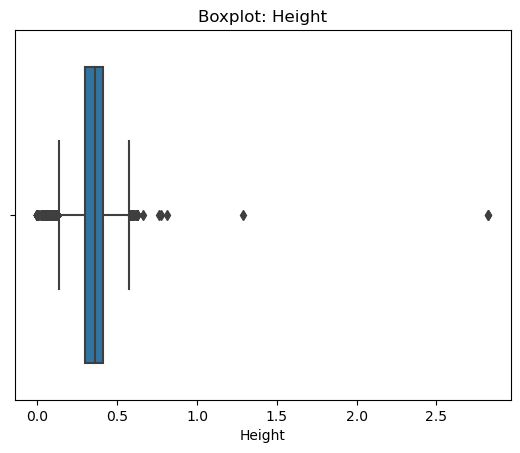

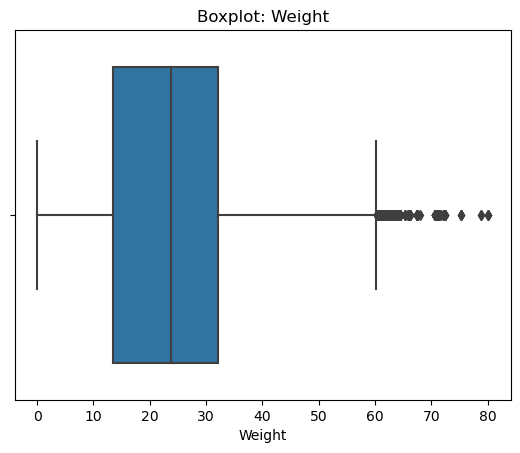

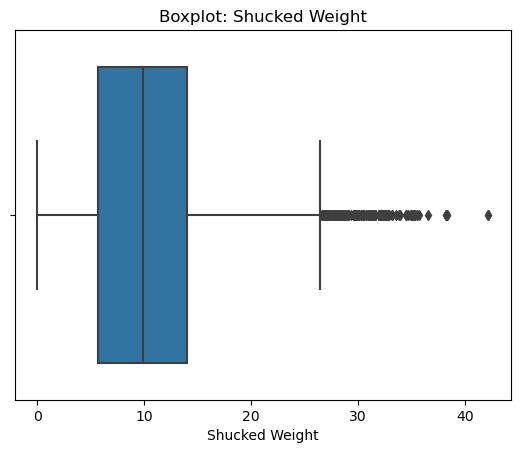

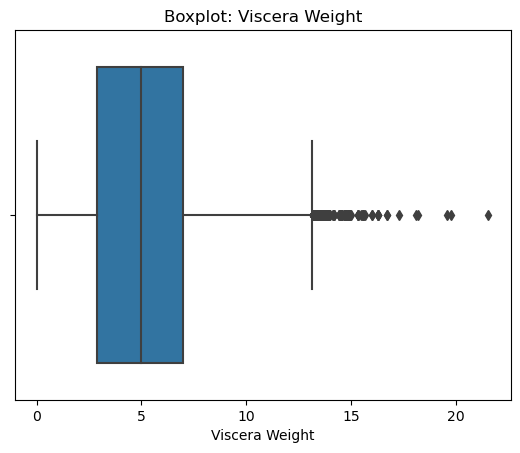

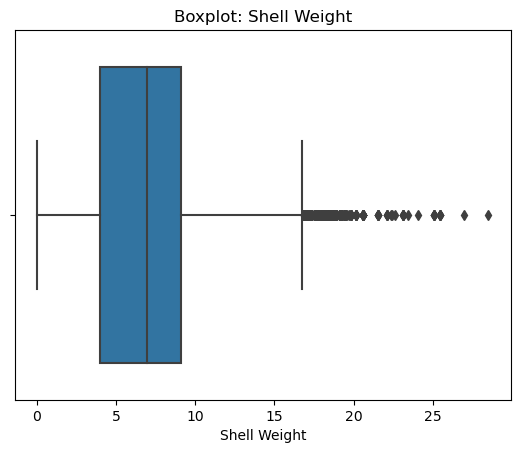

In [25]:
# Visualize the distribution of numerical features using a box plot
num_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']
for feature in num_features:
    sns.boxplot(x=train_df[feature])
    plt.xlabel(feature)
    plt.title(f'Boxplot: {feature}')
    plt.show()

Outliers have been observed, here too ! Let's treat them using z-score.

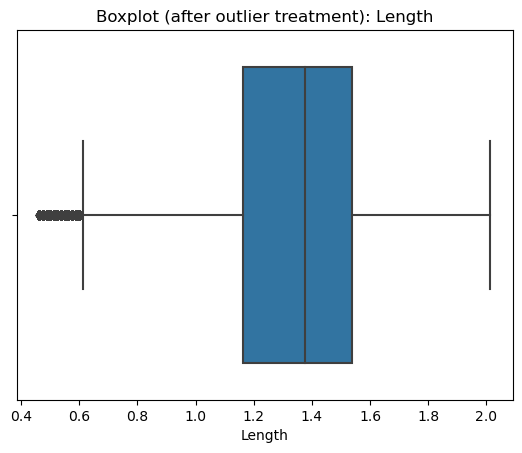

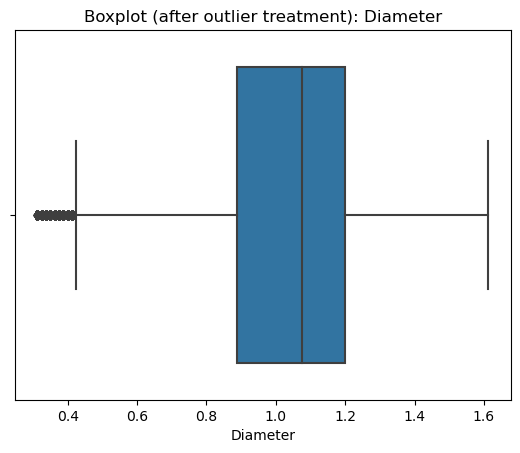

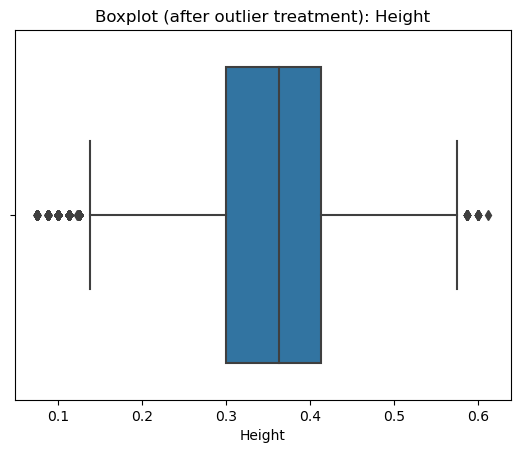

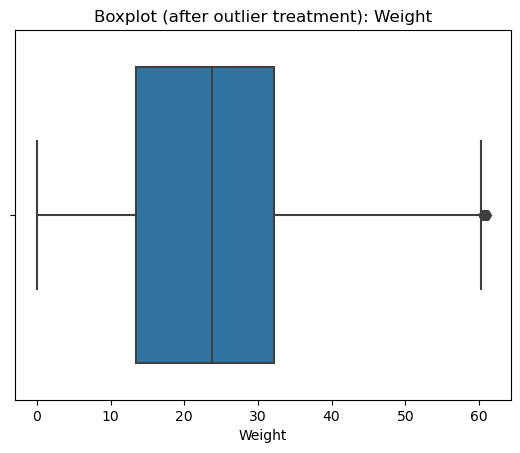

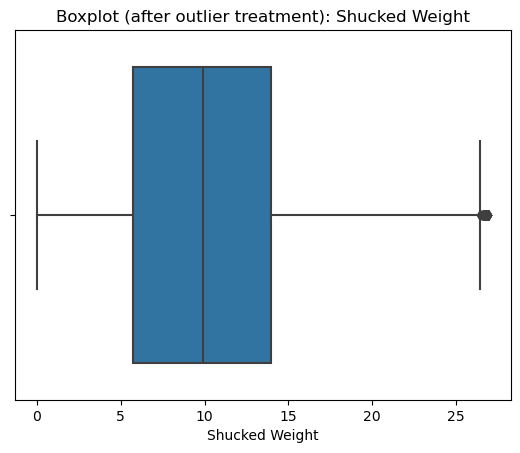

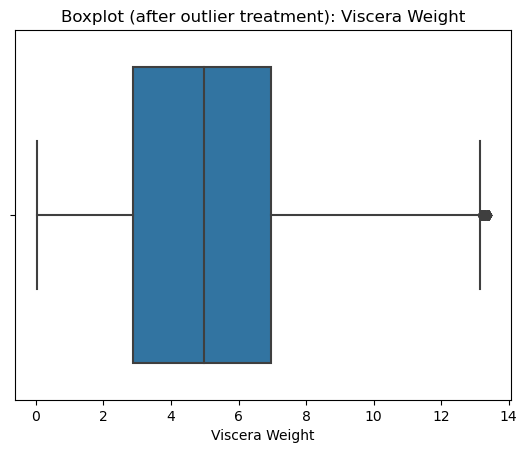

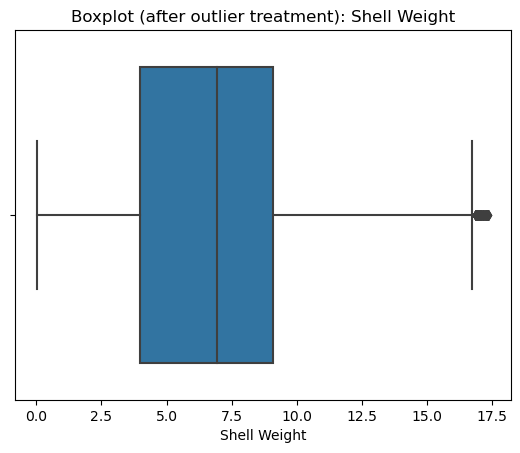

In [26]:
from scipy import stats

num_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

for feature in num_features:
    # Calculate z-scores for each feature
    z_scores = stats.zscore(train_df[feature])
    
    # Define a threshold for outlier detection (e.g., z-score > 3 or z-score < -3)
    threshold = 3
    
    # Identify outliers based on the z-score threshold
    outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
    
    # Perform outlier treatment (e.g., replace outliers with the median value)
    median_value = np.median(train_df[feature])
    train_df.loc[outlier_indices, feature] = median_value
    
    # Replot the boxplot after outlier treatment
    sns.boxplot(x=train_df[feature])
    plt.xlabel(feature)
    plt.title(f'Boxplot (after outlier treatment): {feature}')
    plt.show()


Outliers have been significantly removed, now !

In [27]:
# check the final length of the dataframe after EDA
len(train_df)

74051

In [28]:
train_df

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Volume,Age_zscore,Weight_Group
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0.671953,-0.304805,0-500
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0.249563,-0.619749,0-500
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0.578848,-0.304805,0-500
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1.200625,0.325083,0-500
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0.427148,-0.619749,0-500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74046,74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10,0.918271,0.010139,0-500
74047,74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6,0.254977,-1.249637,0-500
74048,74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10,0.736312,0.010139,0-500
74049,74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8,0.364697,-0.619749,0-500


In [29]:
# Additional step of data pre-processing that is mandatory after our EDA.
categorical_columns = ['Sex', 'Weight_Group']

# Perform dummy encoding with drop_first=True
train_df = pd.get_dummies(train_df, columns=categorical_columns)


The `drop_first=True` parameter usually ensures that the first category of each encoded column is dropped, which helps to avoid multicollinearity but here, we avoided that !

In [30]:
#visualizing the final train_df
train_df

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Volume,Age_zscore,Sex_F,Sex_I,Sex_M,Weight_Group_0-500,Weight_Group_500-1000,Weight_Group_1000-1500,Weight_Group_1500-2000
0,0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0.671953,-0.304805,0,1,0,1,0,0,0
1,1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0.249563,-0.619749,0,1,0,1,0,0,0
2,2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0.578848,-0.304805,0,0,1,1,0,0,0
3,3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1.200625,0.325083,1,0,0,1,0,0,0
4,4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0.427148,-0.619749,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74046,74046,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10,0.918271,0.010139,1,0,0,1,0,0,0
74047,74047,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6,0.254977,-1.249637,0,1,0,1,0,0,0
74048,74048,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10,0.736312,0.010139,1,0,0,1,0,0,0
74049,74049,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8,0.364697,-0.619749,0,1,0,1,0,0,0


In [31]:
#dropping Age Score since that will not be available in the test_df
# Drop the 'Age_zscore' column from test_df
train_df = train_df.drop('Age_zscore', axis=1)


## 4. Model Selection

In [32]:
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(['id', 'Age'], axis=1), train_df['Age'], test_size=0.2, random_state=42)


In [33]:
# Initialize the models
xgb_model = XGBRegressor()
catboost_model = CatBoostRegressor()
lgbm_model = LGBMRegressor()
rf_model = RandomForestRegressor()
et_model = ExtraTreesRegressor()
knn_model = KNeighborsRegressor()
lasso_model = Lasso()
ridge_model = Ridge()

In [34]:
# Fit the models on the training data
xgb_model.fit(X_train, y_train)
catboost_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
et_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

Learning rate set to 0.078028
0:	learn: 3.0624401	total: 57.8ms	remaining: 57.7s
1:	learn: 2.9674070	total: 66.1ms	remaining: 33s
2:	learn: 2.8810147	total: 74.8ms	remaining: 24.8s
3:	learn: 2.8046128	total: 82.9ms	remaining: 20.6s
4:	learn: 2.7346791	total: 92.5ms	remaining: 18.4s
5:	learn: 2.6718534	total: 101ms	remaining: 16.8s
6:	learn: 2.6140307	total: 110ms	remaining: 15.6s
7:	learn: 2.5664032	total: 117ms	remaining: 14.6s
8:	learn: 2.5219766	total: 125ms	remaining: 13.8s
9:	learn: 2.4831340	total: 133ms	remaining: 13.1s
10:	learn: 2.4488948	total: 140ms	remaining: 12.6s
11:	learn: 2.4164016	total: 148ms	remaining: 12.2s
12:	learn: 2.3900716	total: 156ms	remaining: 11.8s
13:	learn: 2.3658594	total: 164ms	remaining: 11.5s
14:	learn: 2.3443753	total: 172ms	remaining: 11.3s
15:	learn: 2.3242683	total: 180ms	remaining: 11.1s
16:	learn: 2.3045029	total: 188ms	remaining: 10.9s
17:	learn: 2.2886297	total: 197ms	remaining: 10.8s
18:	learn: 2.2753598	total: 206ms	remaining: 10.6s
19:	lear

Ridge()

In [35]:
# Create a list of models for VotingRegressor
estimators = [
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('lgbm', lgbm_model),
    ('rf', rf_model),
    ('et', et_model),
    ('knn', knn_model),
    ('lasso', lasso_model),
    ('ridge', ridge_model)
]

In [36]:
# Initialize the VotingRegressor with the list of models
voting_model = VotingRegressor(estimators)


In [37]:
# Fit the VotingRegressor on the training data
voting_model.fit(X_train, y_train)


Learning rate set to 0.078028
0:	learn: 3.0624401	total: 10.9ms	remaining: 10.9s
1:	learn: 2.9674070	total: 19.2ms	remaining: 9.58s
2:	learn: 2.8810147	total: 28.3ms	remaining: 9.41s
3:	learn: 2.8046128	total: 36.7ms	remaining: 9.14s
4:	learn: 2.7346791	total: 45.6ms	remaining: 9.07s
5:	learn: 2.6718534	total: 54.7ms	remaining: 9.07s
6:	learn: 2.6140307	total: 63.1ms	remaining: 8.94s
7:	learn: 2.5664032	total: 71.6ms	remaining: 8.88s
8:	learn: 2.5219766	total: 80.9ms	remaining: 8.91s
9:	learn: 2.4831340	total: 88.8ms	remaining: 8.79s
10:	learn: 2.4488948	total: 97.3ms	remaining: 8.74s
11:	learn: 2.4164016	total: 106ms	remaining: 8.74s
12:	learn: 2.3900716	total: 115ms	remaining: 8.71s
13:	learn: 2.3658594	total: 123ms	remaining: 8.65s
14:	learn: 2.3443753	total: 132ms	remaining: 8.66s
15:	learn: 2.3242683	total: 140ms	remaining: 8.62s
16:	learn: 2.3045029	total: 149ms	remaining: 8.61s
17:	learn: 2.2886297	total: 157ms	remaining: 8.57s
18:	learn: 2.2753598	total: 166ms	remaining: 8.57s


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7e82c8d16f20>),
                            ('lgbm', LGBMRegressor()),
                            ('rf', RandomForestRegressor()),
                            ('et', ExtraTreesRegressor()),
                            ('knn', KNeighborsRegressor()), ('lasso', Lasso()),
                            ('ridge', Ridge())])

In [38]:
# Evaluate the models on the validation data
xgb_preds = xgb_model.predict(X_val)
catboost_preds = catboost_model.predict(X_val)
lgbm_preds = lgbm_model.predict(X_val)
rf_preds = rf_model.predict(X_val)
et_preds = et_model.predict(X_val)
knn_preds = knn_model.predict(X_val)
lasso_preds = lasso_model.predict(X_val)
ridge_preds = ridge_model.predict(X_val)
voting_preds = voting_model.predict(X_val)


In [39]:
# Calculate RMSE (Root Mean Squared Error) for each model
xgb_rmse = mean_squared_error(y_val, xgb_preds, squared=False)
catboost_rmse = mean_squared_error(y_val, catboost_preds, squared=False)
lgbm_rmse = mean_squared_error(y_val, lgbm_preds, squared=False)
rf_rmse = mean_squared_error(y_val, rf_preds, squared=False)
et_rmse = mean_squared_error(y_val, et_preds, squared=False)
knn_rmse = mean_squared_error(y_val, knn_preds, squared=False)
lasso_rmse = mean_squared_error(y_val, lasso_preds, squared=False)
ridge_rmse = mean_squared_error(y_val, ridge_preds, squared=False)
voting_rmse = mean_squared_error(y_val, voting_preds, squared=False)


In [40]:
print("RMSE for XGBoost:", xgb_rmse)
print("RMSE for CatBoost:", catboost_rmse)
print("RMSE for LightGBM:", lgbm_rmse)
print("RMSE for Random Forest:", rf_rmse)
print("RMSE for Extra Trees:", et_rmse)
print("RMSE for KNN:", knn_rmse)
print("RMSE for Lasso:", lasso_rmse)
print("RMSE for Ridge:", ridge_rmse)
print("RMSE for VotingRegressor:", voting_rmse)

RMSE for XGBoost: 2.0559992130446165
RMSE for CatBoost: 2.037002433298991
RMSE for LightGBM: 2.0386645035607396
RMSE for Random Forest: 2.102542019819905
RMSE for Extra Trees: 2.1063046686636975
RMSE for KNN: 2.21824670838328
RMSE for Lasso: 2.4854297494435946
RMSE for Ridge: 2.1720648462791234
RMSE for VotingRegressor: 2.049379990129259


## 5. Hyperparameter tuning

In [41]:
# Initialize the models
xgb_model = XGBRegressor()
catboost_model = CatBoostRegressor()
lgbm_model = LGBMRegressor()
rf_model = RandomForestRegressor()
et_model = ExtraTreesRegressor()
knn_model = KNeighborsRegressor()
lasso_model = Lasso()
ridge_model = Ridge()


In [42]:
# Define the parameter grid for each model
xgb_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5]}
catboost_param_grid = {'iterations': [100, 200, 300], 'depth': [3, 4, 5]}
lgbm_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5]}
rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5]}
et_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5]}
knn_param_grid = {'n_neighbors': [3, 5, 7]}
lasso_param_grid = {'alpha': [0.1, 1.0, 10.0]}
ridge_param_grid = {'alpha': [0.1, 1.0, 10.0]}


In [43]:
# Perform grid search for each model
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, scoring='neg_mean_squared_error')
catboost_grid = GridSearchCV(catboost_model, catboost_param_grid, scoring='neg_mean_squared_error')
lgbm_grid = GridSearchCV(lgbm_model, lgbm_param_grid, scoring='neg_mean_squared_error')
rf_grid = GridSearchCV(rf_model, rf_param_grid, scoring='neg_mean_squared_error')
et_grid = GridSearchCV(et_model, et_param_grid, scoring='neg_mean_squared_error')
knn_grid = GridSearchCV(knn_model, knn_param_grid, scoring='neg_mean_squared_error')
lasso_grid = GridSearchCV(lasso_model, lasso_param_grid, scoring='neg_mean_squared_error')
ridge_grid = GridSearchCV(ridge_model, ridge_param_grid, scoring='neg_mean_squared_error')


In [44]:
# Fit the grid search on the training data
xgb_grid.fit(X_train, y_train)
catboost_grid.fit(X_train, y_train)
lgbm_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)
et_grid.fit(X_train, y_train)
knn_grid.fit(X_train, y_train)
lasso_grid.fit(X_train, y_train)
ridge_grid.fit(X_train, y_train)


Learning rate set to 0.489712
0:	learn: 2.6510032	total: 6.96ms	remaining: 689ms
1:	learn: 2.4429683	total: 12.2ms	remaining: 597ms
2:	learn: 2.3441203	total: 17.3ms	remaining: 558ms
3:	learn: 2.2933705	total: 22.1ms	remaining: 530ms
4:	learn: 2.2637628	total: 26.7ms	remaining: 507ms
5:	learn: 2.2325689	total: 32ms	remaining: 502ms
6:	learn: 2.2134879	total: 36.4ms	remaining: 484ms
7:	learn: 2.1939756	total: 41.1ms	remaining: 473ms
8:	learn: 2.1857158	total: 45.5ms	remaining: 460ms
9:	learn: 2.1711578	total: 50.9ms	remaining: 458ms
10:	learn: 2.1595343	total: 55.7ms	remaining: 451ms
11:	learn: 2.1459552	total: 60.5ms	remaining: 444ms
12:	learn: 2.1370924	total: 65.2ms	remaining: 436ms
13:	learn: 2.1334743	total: 69.7ms	remaining: 428ms
14:	learn: 2.1270101	total: 74.6ms	remaining: 423ms
15:	learn: 2.1201342	total: 79.5ms	remaining: 418ms
16:	learn: 2.1169128	total: 84ms	remaining: 410ms
17:	learn: 2.1134080	total: 88.8ms	remaining: 405ms
18:	learn: 2.1081924	total: 93.6ms	remaining: 39

GridSearchCV(estimator=Ridge(), param_grid={'alpha': [0.1, 1.0, 10.0]},
             scoring='neg_mean_squared_error')

In [45]:
# Get the best models with the best hyperparameters
xgb_model = xgb_grid.best_estimator_
catboost_model = catboost_grid.best_estimator_
lgbm_model = lgbm_grid.best_estimator_
rf_model = rf_grid.best_estimator_
et_model = et_grid.best_estimator_
knn_model = knn_grid.best_estimator_
lasso_model = lasso_grid.best_estimator_
ridge_model = ridge_grid.best_estimator_


In [46]:
# Create a list of models for VotingRegressor
estimators = [
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('lgbm', lgbm_model),
    ('rf', rf_model),
    ('et', et_model),
    ('knn', knn_model),
    ('lasso', lasso_model),
    ('ridge', ridge_model)
]


In [47]:
# Initialize the VotingRegressor with the list of models
voting_model = VotingRegressor(estimators)


In [48]:
# Fit the VotingRegressor on the training data
voting_model.fit(X_train, y_train)


Learning rate set to 0.20766
0:	learn: 2.9190985	total: 7.5ms	remaining: 2.24s
1:	learn: 2.7434786	total: 13.5ms	remaining: 2.01s
2:	learn: 2.6174900	total: 19.6ms	remaining: 1.94s
3:	learn: 2.5285909	total: 25.1ms	remaining: 1.86s
4:	learn: 2.4545092	total: 30.7ms	remaining: 1.81s
5:	learn: 2.4016535	total: 36.2ms	remaining: 1.77s
6:	learn: 2.3632757	total: 42ms	remaining: 1.76s
7:	learn: 2.3310225	total: 48ms	remaining: 1.75s
8:	learn: 2.3122308	total: 53.6ms	remaining: 1.73s
9:	learn: 2.2956829	total: 59ms	remaining: 1.71s
10:	learn: 2.2833687	total: 64.2ms	remaining: 1.69s
11:	learn: 2.2595527	total: 69.9ms	remaining: 1.68s
12:	learn: 2.2436554	total: 75.5ms	remaining: 1.67s
13:	learn: 2.2355162	total: 80.7ms	remaining: 1.65s
14:	learn: 2.2248356	total: 86.1ms	remaining: 1.64s
15:	learn: 2.2152073	total: 92.2ms	remaining: 1.64s
16:	learn: 2.2090400	total: 97.5ms	remaining: 1.62s
17:	learn: 2.2011738	total: 103ms	remaining: 1.61s
18:	learn: 2.1921863	total: 109ms	remaining: 1.6s
19:

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          predictor=None, random_state=None, ...)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7e82c8d17e50>),
                            ('lgbm',
                             LGBMRegressor(max_depth=4, n_estimators=300)),
                            ('rf',
                             RandomForestRegressor(max_depth=5,
                                                   n_estimators=200)),
                            ('et',
                             ExtraTreesRegressor(max_depth=5,
                                                 n_estimators=300)),
                            ('knn', KNeighborsRegressor(n_neighbors=7)),
                            ('lasso', Lasso(alpha=0.1)),
                            ('ridge', Ridge(alpha=0.1))])

In [49]:
# Evaluate the models on the validation data
xgb_preds = xgb_model.predict(X_val)
catboost_preds = catboost_model.predict(X_val)
lgbm_preds = lgbm_model.predict(X_val)
rf_preds = rf_model.predict(X_val)
et_preds = et_model.predict(X_val)
knn_preds = knn_model.predict(X_val)
lasso_preds = lasso_model.predict(X_val)
ridge_preds = ridge_model.predict(X_val)
voting_preds = voting_model.predict(X_val)


In [50]:
# Calculate RMSE (Root Mean Squared Error) for each model
xgb_rmse = mean_squared_error(y_val, xgb_preds, squared=False)
catboost_rmse = mean_squared_error(y_val, catboost_preds, squared=False)
lgbm_rmse = mean_squared_error(y_val, lgbm_preds, squared=False)
rf_rmse = mean_squared_error(y_val, rf_preds, squared=False)
et_rmse = mean_squared_error(y_val, et_preds, squared=False)
knn_rmse = mean_squared_error(y_val, knn_preds, squared=False)
lasso_rmse = mean_squared_error(y_val, lasso_preds, squared=False)
ridge_rmse = mean_squared_error(y_val, ridge_preds, squared=False)
voting_rmse = mean_squared_error(y_val, voting_preds, squared=False)


In [51]:
# Create a dictionary to store the RMSE values
rmse_values = {
    'XGBoost': xgb_rmse,
    'CatBoost': catboost_rmse,
    'LightGBM': lgbm_rmse,
    'Random Forest': rf_rmse,
    'Extra Trees': et_rmse,
    'KNN': knn_rmse,
    'Lasso': lasso_rmse,
    'Ridge': ridge_rmse,
    'VotingRegressor': voting_rmse
}

In [52]:
# Find the model with the lowest RMSE
best_model = min(rmse_values, key=rmse_values.get)


In [53]:
print("RMSE for XGBoost:", xgb_rmse)
print("RMSE for CatBoost:", catboost_rmse)
print("RMSE for LightGBM:", lgbm_rmse)
print("RMSE for Random Forest:", rf_rmse)
print("RMSE for Extra Trees:", et_rmse)
print("RMSE for KNN:", knn_rmse)
print("RMSE for Lasso:", lasso_rmse)
print("RMSE for Ridge:", ridge_rmse)
print("RMSE for VotingRegressor:", voting_rmse)

RMSE for XGBoost: 2.046782764773491
RMSE for CatBoost: 2.0419233034097655
RMSE for LightGBM: 2.03709955547444
RMSE for Random Forest: 2.150305086229715
RMSE for Extra Trees: 2.25752129591192
RMSE for KNN: 2.162859214756904
RMSE for Lasso: 2.248316233743561
RMSE for Ridge: 2.1719166505028724
RMSE for VotingRegressor: 2.0686763459649367


In [54]:
print("Best Model:", best_model)

Best Model: LightGBM


## 6. Feature Importance

In [55]:
# Get feature importances from one of the best model(XGB)
feature_importances = xgb_model.feature_importances_


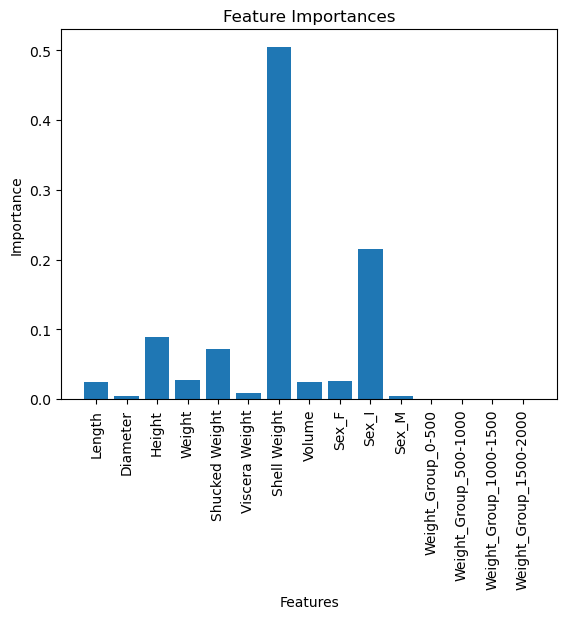

In [56]:
# Plot feature importances
plt.bar(X_train.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()

## 7. Model Interpretation

In [57]:
import shap


/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

In [65]:
explainer = shap.Explainer(lgbm_model)
shap_values = explainer.shap_values(X_val)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


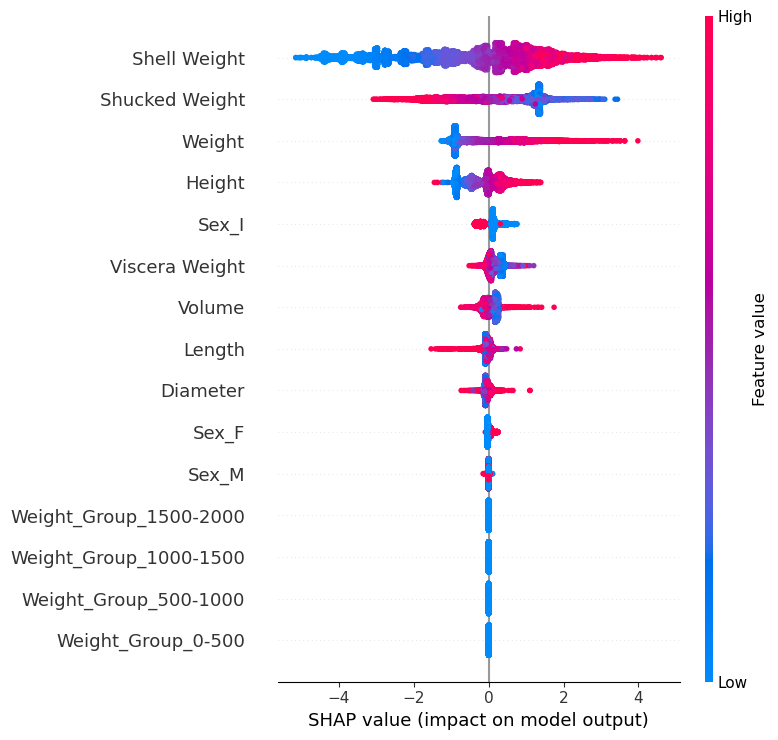

In [66]:
# Plot summary plot for SHAP values
shap.summary_plot(shap_values, X_val)


## 8. Generating Submission

#### Applying similar transformations to test_df

In [72]:
test_df

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Volume
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552,0.220172
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930,0.283723
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415,0.413207
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676,0.593117
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066,0.248227
...,...,...,...,...,...,...,...,...,...,...
49363,123414,F,1.3000,1.0375,0.3250,16.315137,6.690482,5.173784,3.756309,0.438344
49364,123415,I,1.0375,0.7625,0.2625,10.276694,4.436697,1.998640,3.543687,0.207662
49365,123416,F,1.4875,1.1625,0.3625,31.382897,11.396499,6.846404,8.788345,0.626842
49366,123417,F,1.2375,0.9500,0.2875,15.663099,6.095142,3.727959,4.961163,0.337992


In [73]:
# Explore the distribution of 'Age' across different ranges of 'Weight'
test_df['Weight_Group'] = pd.cut(test_df['Weight'], bins=[0, 500, 1000, 1500, 2000], labels=['0-500', '500-1000', '1000-1500', '1500-2000'])
# Additional step of data pre-processing that is mandatory after our EDA.
categorical_columns = ['Sex', 'Weight_Group']

# Perform dummy encoding with drop_first=True
test_df = pd.get_dummies(test_df, columns=categorical_columns)

In [74]:
# Use the best model to predict on the test data
test_preds = lgbm_model.predict(test_df.drop(['id'], axis=1))


In [77]:
# Create the submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'Age': test_preds})
submission_df.to_csv('submission.csv', index=False)


In [78]:
submission_df

,id,Age
0,74051,7.543229
1,74052,7.745897
2,74053,10.870145
3,74054,9.206794
4,74055,7.443246
...,...,...
49363,123414,9.443005
49364,123415,8.277206
49365,123416,13.174603
49366,123417,10.011474
